# Stage 2: Gradient-Boosted Decistion Tree
This notebook applies a Gradient Boosting Decision Tree (GBDT) model to enhance the performance of our Convolutional Neural Networks (CNNs). The GBDT model takes the predictions of the CNNs as well as other features as inputs, and outputs a final prediction. To use this notebook, the CNNs must have been previously trained and saved. Additionally, all CNNs must have been trained on the same dataset, with a portion of the data set aside for the GBDT model. This ensures that the results are consistent and valid.

In [378]:
import numpy as np
import pandas as pd
import skimage as sk
import matplotlib.pyplot as plt
import os
from PIL import Image
from shutil import copyfile, rmtree
import re
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from PIL import Image
import seaborn as sns


SOURCE_DF = '/home/mniederer/workspace/data/new_material/umrisse_with_all_data_and_LoD2.csv'
SOURCE_MODELS = '/home/mniederer/workspace/Geo-KI/Notebooks/Trained_Models'
SOURCE_DATA_NORMAL = '/home/mniederer/workspace/data/cross_validation_normal/pass_1/test' # only use test data
SOURCE_DATA_PATCHES = '/home/mniederer/workspace/data/cross_validation_patches/pass_1/test' # only use test data

## Read DF and Load Models
We begin by reading a csv file that contains our roof data into a dataframe. The data includes attributes such as roof material, surface area, roof shape, and more. Next, we load all the CNN models that we will use to predict the roof materials based on our test images.


In [379]:
df = pd.read_csv(SOURCE_DF, index_col=0)
model_own = load_model(os.path.join(SOURCE_MODELS, 'CNN_own_model_stage_2.h5'))
model_transfer = load_model(os.path.join(SOURCE_MODELS, 'CNN_Transfer_stage_2.h5'))
model_patches = load_model(os.path.join(SOURCE_MODELS, 'CNN_Patches_stage_2.h5'))

## Prepare Data
We employ the ImageDataGenerator class from the Keras library to preprocess our data for both the CNN from scratch and the CNN with Transfer Learning. For the CNN with patches, we manually prepare the data so that we can later aggregate the predictions of patches corresponding to the same image.

In [380]:
#### Normal images #####
test_datagen_normal = ImageDataGenerator(rescale=1./255)
test_generator_normal = test_datagen_normal.flow_from_directory(os.path.join(SOURCE_DATA_NORMAL),
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=False)



#### Patches #####
# We do this manually
#classes
classes = ['Beton', 'Bitumen','Asbest|Faserzement', 'Metallbahn', 'Kunststoffbahn',
 'Ziegel', 'Schiefer', 'PVC|Polycarbonat', 'Dachbegrünung', 'Glas', 'Kupfer']

# class to output of model
roof_Types_dict = { 'Asbest|Faserzement':0, 'Beton':1, 'Bitumen':2, 'Dachbegrünung':3, 'Glas': 4, 'Kunststoffbahn': 5,
                    'Kupfer': 6, 'Metallbahn': 7, 'PVC|Polycarbonat':8, 'Schiefer': 9, 'Ziegel': 10}

previous_id = '0' # we save the previous id of patches to identify, when a new image appears
previous_material = 'Beton'
imageList = [] # this is gonna be a list of lists. the images are the items of the outer list, each image is a list of patches
y_test_patches = [] # these are the truth values. For each image one class
ids = [] # the ids of the images. This is needed to allocate the predictions to the right images (for Stage 2)
current_image = []

for material in classes:
    list = os.listdir(os.path.join(SOURCE_DATA_PATCHES, material))
    list.sort() #sorted by name, so patches belonging to same roof are adjacent
    for patch in list:
        new_image = Image.open(os.path.join(SOURCE_DATA_PATCHES, material,patch))
        new_image = np.array(new_image)
        new_image = new_image.astype('float32')
        new_image /= 255.0
        current_id = patch.split('_')[2]
        # check for new id
        if(current_id != previous_id):
            imageList.append(current_image)
            y_test_patches.append(roof_Types_dict[previous_material])
            ids.append(int(previous_id))
            current_image = []
        current_image.append(new_image)
        previous_id = current_id
        previous_material = material 

imageList.pop(0) #first item is empty list
y_test_patches.pop(0)
ids.pop(0)

Found 1650 images belonging to 11 classes.


0

## Predict with CNNs
We then use all the CNNs to predict the roof materials and store the predictions in our dataframe. We match the predictions with the corresponding images using their ids.

### CNN from scratch

In [356]:
y_test = test_generator_normal.classes
y_pred = np.argmax(model_own.predict(test_generator_normal), axis=1)

print(classification_report(y_test, y_pred))

52/52 [==============================] - 5s 96ms/step
              precision    recall  f1-score   support

           0       0.60      0.41      0.49       179
           1       0.48      0.16      0.24       159
           2       0.61      0.32      0.42       148
           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00        26
           5       0.00      0.00      0.00         2
           7       0.48      0.73      0.58       259
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00        28
          10       0.77      0.94      0.85       814

    accuracy                           0.67      1647
   macro avg       0.39      0.28      0.29      1647
weighted avg       0.62      0.67      0.62      1647



/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

#### Add Predictions to DataFrame

In [382]:
for i,filename in enumerate(test_generator_normal.filenames):
    id = int(filename.split('_')[2].split('.')[0])
    df.loc[ df['id'] == id, 'Pred_Normal'] = y_pred[i]


### Transfer CNN

In [312]:
y_test = test_generator_normal.classes
y_pred = np.argmax(model_transfer.predict(test_generator_normal), axis=1)

print(classification_report(y_test, y_pred))


39/39 [==============================] - 18s 446ms/step
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       135
           1       0.48      0.51      0.50       120
           2       0.68      0.43      0.52       112
           3       0.00      0.00      0.00         4
           4       0.67      0.30      0.41        20
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.55      0.59      0.57       195
           8       0.25      0.24      0.24        21
           9       0.71      0.45      0.56        22
          10       0.83      0.92      0.87       611

    accuracy                           0.71      1243
   macro avg       0.44      0.36      0.39      1243
weighted avg       0.70      0.71      0.70      1243



/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

#### Add Predictions to DataFrame

In [384]:
for i,filename in enumerate(test_generator_normal.filenames):
    id = int(filename.split('_')[2].split('.')[0])
    df.loc[ df['id'] == id, 'Pred_Transfer'] = y_pred[i]


### Patches


In [369]:
y_pred = []
for i in range(len(imageList)):
    prediction = model_patches.predict(np.array(imageList[i]), verbose=0)
    prediction = prediction.argmax(axis=1)
    unique, counts = np.unique(prediction, return_counts=True)
    result = unique[counts.argmax()]
    y_pred.append(result)


print(classification_report(y_test_patches, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.14      0.23       122
           1       0.50      0.12      0.19        92
           2       0.34      0.33      0.33       101
           3       1.00      0.33      0.50         3
           4       1.00      0.21      0.35        14
           5       0.00      0.00      0.00         1
           7       0.56      0.41      0.47       172
           8       0.00      0.00      0.00        18
           9       0.71      0.26      0.38        19
          10       0.64      0.93      0.75       562

    accuracy                           0.60      1104
   macro avg       0.54      0.27      0.32      1104
weighted avg       0.58      0.60      0.54      1104



/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

#### Add Predictions to DataFrame

In [386]:
for i,id in enumerate(ids):
    df.loc[ df['id'] == id, 'Pred_Patches'] = y_pred[i]


## Add Pollution Class to Dataframe
Each roof material translates to a pollution class

In [387]:
def material_to_belastungskategorie (materialString):
    dict = {
        'Beton' : 1,
        'Bitumen' : 3,
        'Asbest|Faserzement' : 1,
        'Metallbahn' : 3,
        'Kunststoffbahn' : 3,
        'Ziegel' : 1,
        'Schiefer' : 1,
        'PVC|Polycarbonat' : 3,
        'Dachbegrünung' : 3,
        'Glas' : 1,
        'Kupfer' : 3
    }
    return dict[materialString]

df['Belastungskategorie'] =  df['mat_qgis'].apply(material_to_belastungskategorie)


## Prepare Data for XGB
We remove all the data from the dataframe that does not belong to our test dataset. Then we rename some features to give them informative English names. To preprocess the data for the XGB library, we convert all categorical data to category type.

In [388]:
df_for_xgb = df.loc[df['Pred_Patches'] < 50, ['mat_qgis', 'ezg', 'id', 'area_type', 'area', 'Shape', 'Height', 'Pred_Normal', 'Pred_Transfer', 'Pred_Patches', 'Belastungskategorie']]

# class to output of model
roof_Types_dict = { 'Asbest|Faserzement':0, 'Beton':1, 'Bitumen':2, 'Dachbegrünung':3, 'Glas': 4, 'Kunststoffbahn': 5,
                    'Kupfer': 6, 'Metallbahn': 7, 'PVC|Polycarbonat':8, 'Schiefer': 9, 'Ziegel': 10}

df_for_xgb['mat_qgis'] = df_for_xgb['mat_qgis'].apply( lambda x : roof_Types_dict[x])
df_for_xgb = df_for_xgb.rename(columns=
                  {
                      'mat_qgis': 'Roof_Material',
                      'area': 'Surface_Area',
                      'Belastungskategorie': 'Pollution_Class',
                      'area_type': 'Region_Type',
                  })

In [389]:
categories = [ 'Roof_Material', 'Region_Type', 'Shape', 'Pred_Normal', 'Pred_Transfer', 'Pred_Patches', 'Pollution_Class']

for c in categories:
    df_for_xgb[c] = df_for_xgb[c].astype('category')

### Evaluation of Features
We evaluate our features based on the Pearson correlation coefficient and display the results in a heatmap.

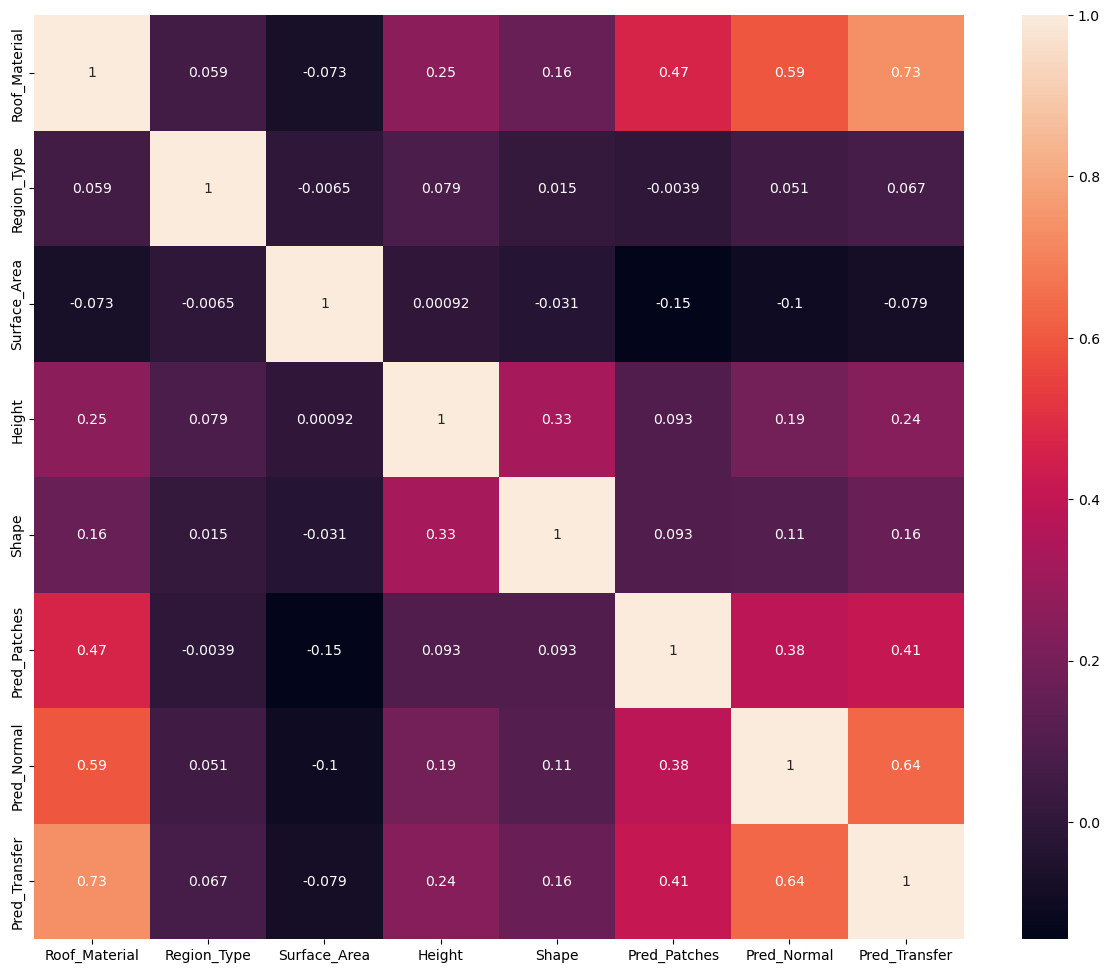

In [365]:
plt.figure(figsize=(15,12))

df_features = df_for_xgb.loc[:,['Roof_Material','Region_Type', 'Surface_Area', 'Height', 'Shape', 'Pred_Patches', 'Pred_Normal', 'Pred_Transfer']]
sns.heatmap(df_features.corr(method='pearson', numeric_only=False), annot=True)
plt.show()

### Feature Selection
We choose our features based on the heatmap above and the feature importance computed by the XGB model. To do this, we experiment with different feature combinations to find the optimal ones.

In [390]:
#X = df_for_xgb.loc[:,['Region_Type', 'Surface_Area', 'Shape', 'Height', 'Pred_Patches', 'Pred_Normal', 'Pred_Transfer']]
X = df_for_xgb.loc[:,['Surface_Area', 'Shape', 'Height', 'Pred_Transfer', 'Pred_Normal']]
#X = df_for_xgb.loc[:,['area_type', 'area', 'Shape']]
#X = df_for_xgb.loc[:,['Pred_patch', 'Pred_normal']]


y_material = df_for_xgb['Roof_Material']
y_PC =  df_for_xgb['Pollution_Class']


### Split and Load Data
We divided our data into a training set and a test set. Next, we loaded our data into an XGB DMatrix, a data structure optimized for XGBoost algorithms. We performed this step for both the roof material classification and the pollution class classification tasks.

In [391]:
# roof material class
# Train-Test-Split
X_train_material, X_test_material, y_train_material, y_test_material = train_test_split(X, y_material, random_state=134)

# Load data into DMatrix
train_material = xgb.DMatrix(X_train_material, y_train_material, enable_categorical=True)
test_material = xgb.DMatrix(X_test_material, y_test_material, enable_categorical=True)

# pollution class
# Train-Test-Split
X_train_PC, X_test_PC, y_train_PC, y_test_PC = train_test_split(X, y_PC, random_state=134)

# Load data into DMatrix
train_PC = xgb.DMatrix(X_train_PC, y_train_PC, enable_categorical=True)
test_PC = xgb.DMatrix(X_test_PC, y_test_PC, enable_categorical=True)

## GBDT: Material
We train our GBDT multiple times to find the optimal parameters for training.

In [424]:
params = {
    'max_depth' : 4,  # in 3-10
    'eta': 0.28,  # learning rate between [0,1] default 0.3
    'objective': 'multi:softmax', #set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)
    'num_class': 11,
    'booster' : 'gbtree',  # gbtree or gblinear
    'alpha' :   0.4,   # L1 regularization term on weight (analogous to Lasso regression)
    'lambda' :  0.5, #4, # L2 regularization term on weights (analogous to Ridge regression)
    'gamma' : 0,  # Gamma specifies the minimum loss reduction required to make a split
    'max_cat_to_onehot' : 50
    }
n = 9  # num of trees

model = xgb.train(
   params=params,
   dtrain=train_material,
   num_boost_round = n,
)

y_pred = model.predict(test_material)
acc = accuracy_score(y_test_material, y_pred)

print(f"Accuracy of the model: {acc:.3%}")

print(classification_report(y_test_material, y_pred))

Accuracy of the model: 71.809%
              precision    recall  f1-score   support

           0       0.52      0.49      0.50        35
           1       0.00      0.00      0.00        32
           2       0.38      0.62      0.47        39
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           7       0.68      0.78      0.73        63
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         2
          10       0.87      0.94      0.90       191

    accuracy                           0.72       376
   macro avg       0.27      0.31      0.29       376
weighted avg       0.64      0.72      0.68       376



/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

### Cross-Validation
We performed a 5-fold cross-validation to obtain a robust result.

In [425]:
data_dmatrix = xgb.DMatrix(data=X, label=y_material, enable_categorical=True)

cv_score = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=9, metrics="merror", as_pandas=True, seed=123)

print(f"Average error of the model: {cv_score['test-merror-mean'].mean():.2%}")


Average error of the model: 28.42%


### Feature Importance
We use the XGBoost Library to estimate the feature importance

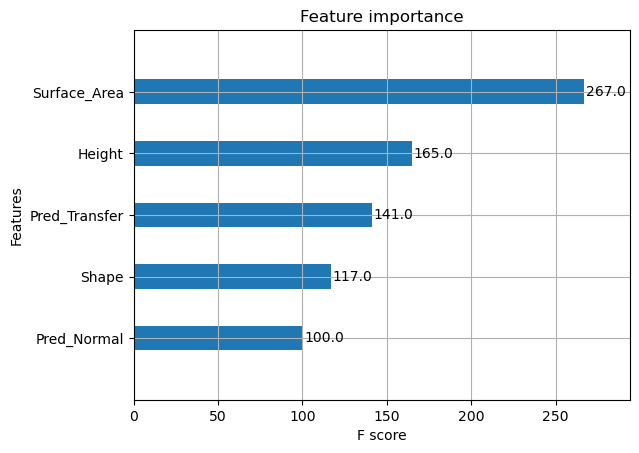

In [428]:
xgb.plot_importance(model, height=0.4)



## GBDT: Pollution Class

We train our GBDT multiple times to find the optimal parameters for training.

In [430]:
params = {
    'max_depth' : 4,  # in 3-10
    'eta': 0.28,  # Lernrate zwischen [0,1] default 0.3
    'objective': 'multi:softmax', #set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)
    'num_class': 11,
    'booster' : 'gbtree',  # gbtree or gblinear
    'alpha' :   0.4, #0.8,  # L1 regularization term on weight (analogous to Lasso regression)
    'lambda' :  0.5, #4, # L2 regularization term on weights (analogous to Ridge regression)
    'gamma' : 0,  # Gamma specifies the minimum loss reduction required to make a split
    'max_cat_to_onehot' : 50
    }
n = 10  # Anzahl der Bäume

model_BK = xgb.train(
   params=params,
   dtrain=train_PC,
   num_boost_round = n,
)

y_pred = model_BK.predict(test_PC)
acc = accuracy_score(y_test_PC, y_pred)

print(f"Accuracy of the model: {acc:.3%}")
print(classification_report(y_test_PC, y_pred))

Accuracy of the model: 84.840%
              precision    recall  f1-score   support

           1       0.88      0.91      0.89       265
           3       0.76      0.70      0.73       111

    accuracy                           0.85       376
   macro avg       0.82      0.81      0.81       376
weighted avg       0.85      0.85      0.85       376



## Save GBDT model
We save the GBDT model in JSON format.

In [431]:
model.save_model('GBDT.json')